In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import swifter

import re
import statistics


INPUT_FOLDER = ""
DATA_FOLDER = "data/"

In [41]:
def basic_parse_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Drop rows with missing values
    df = df.dropna()
    # Drop duplicate rows
    df = df.drop_duplicates(subset=["hadm_id", "icd_code"])
    return df


def parse_codes(df: pd.DataFrame) -> pd.DataFrame:
    # Split the icd_code into the first 3 characters and the rest
    df = df.dropna(subset=["icd_code"])
    df = df.drop_duplicates(subset=["hadm_id", "icd_code"])
    # Group by subject-id, hadm-id, and icd-version and aggregate the icd-codes into a list
    df = (
        df.groupby(["subject_id", "hadm_id", "icd_version"])
        .agg({"icd_code": list})
        .reset_index()
    )
    return df


def add_prefix(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    """For each code in the icd_column, add a string prefix to the front followed by a hyphen.

    Codes are assumed to be strings.
    Returns the resulting dataframe."""
    df["icd_code"] = df["icd_code"].apply(lambda x: prefix + "-" + x)
    return df


def plot_top_n(df: pd.DataFrame, title: str, top_n: int, icd_version: int) -> None:
    """
    Plots the top n most frequent codes in a bar graph. Include the full name of the code hyphenated with the code.
    """
    df = df[df.icd_version == icd_version]
    # Get the top n most frequent codes
    top_codes = df.icd_code.value_counts().head(top_n)

    # Plot the graph
    top_codes.plot(kind="bar")
    plt.title(title)
    plt.show()

def get_top_n_codes(df: pd.DataFrame, top_n: int, icd_version: int) -> None:
    """
    Plots the top n most frequent codes in a bar graph. Include the full name of the code hyphenated with the code.
    """
    df = df[df.icd_version == icd_version]
    # Get the top n most frequent codes
    top_codes = df.icd_code.value_counts().head(top_n)
    return top_codes


def extra_processing(text: str) -> str:
    # Remove fluff text such as "Date of Birth: ___", "Name: ___", "Unit No: ___"
    fluff_text = [
        "Date of Birth:",
        "Name:",
        "Unit No:",
        "Admission Date:",
        "Attending:",
        "Discharge Date:",
    ]
    for fluff in fluff_text:
        text = text.replace(fluff, "")

    # Strip

    text = re.sub(r"^[\s_]*", "", text)
    text = text.strip()
    return text

def prune_text(df: pd.DataFrame, max_len = 40000):
    # Remove entries that have text that includes more than max_tokens
    df = df[df.text.str.len() <= max_len]
    return df



In [3]:
diagnoses_icd = pd.read_csv(
    INPUT_FOLDER + "mimic-iv-2.2/hosp/diagnoses_icd.csv.gz",
    compression="gzip",
)

procedures_icd = pd.read_csv(
    INPUT_FOLDER + "mimic-iv-2.2/hosp/procedures_icd.csv.gz",
    compression="gzip",
)

# Remove all codes with less than 10 occurances
diagnoses_icd = diagnoses_icd.groupby("icd_code").filter(lambda x: len(x) > 10)
procedures_icd = procedures_icd.groupby("icd_code").filter(lambda x: len(x) > 10)

diagnoses_icd = basic_parse_dataframe(diagnoses_icd)
procedures_icd = basic_parse_dataframe(procedures_icd)

# Add the prefix to the icd_code
pre_diagnoses_icd = add_prefix(diagnoses_icd, "d")
pre_procedures_icd = add_prefix(procedures_icd, "p")

diagnoses_icd = parse_codes(pre_diagnoses_icd)
procedures_icd = parse_codes(pre_procedures_icd)

# Rename the icd_code column to icd_diag and icd_proc
diagnoses_icd = diagnoses_icd.rename(columns={"icd_code": "icd_diag"})
procedures_icd = procedures_icd.rename(columns={"icd_code": "icd_proc"})

In [4]:
# Split into ICD version 9 and version 10
diagnoses_icd9 = diagnoses_icd[diagnoses_icd.icd_version == 9]
diagnoses_icd10 = diagnoses_icd[diagnoses_icd.icd_version == 10]

procedures_icd9 = procedures_icd[procedures_icd.icd_version == 9]
procedures_icd10 = procedures_icd[procedures_icd.icd_version == 10]

In [ ]:
diagnoses_icd9.head()

In [ ]:
procedures_icd10.head()

In [7]:
# Get total label count. This is the number of diagnoses and procedure codes, seperated into icd9 and icd10

diagnoses_codes = pd.read_csv(
    INPUT_FOLDER + "mimic-iv-2.2/hosp/d_icd_diagnoses.csv.gz",
    compression="gzip",
)

procedure_codes = pd.read_csv(
    INPUT_FOLDER + "mimic-iv-2.2/hosp/d_icd_procedures.csv.gz",
    compression="gzip",
)

# Add the prefix to the icd_code
diagnoses_codes = add_prefix(diagnoses_codes, "d")
procedure_codes = add_prefix(procedure_codes, "p")

# Split into ICD version 9 and version 10
icd9_diagnoses_codes = diagnoses_codes[diagnoses_codes.icd_version == 9]
icd10_diagnoses_codes = diagnoses_codes[diagnoses_codes.icd_version == 10]

icd9_procedures_codes = procedure_codes[procedure_codes.icd_version == 9]
icd10_procedures_codes = procedure_codes[procedure_codes.icd_version == 10]

# Merge the diagnoses and procedures
icd9_codes = pd.concat([icd9_diagnoses_codes, icd9_procedures_codes])
icd10_codes = pd.concat([icd10_diagnoses_codes, icd10_procedures_codes])

# Print counts entries
print("ICD9 count:", len(icd9_codes))
print("ICD10 count:", len(icd10_codes))

ICD9 count: 18554
ICD10 count: 176478


In [ ]:
# Print rows where hadm_id is "25022803"
diagnoses_icd9[diagnoses_icd9.hadm_id == 25022803]

In [ ]:
icd9_codes.head()

In [ ]:
mimic_notes = pd.read_csv(
    INPUT_FOLDER + "mimic-iv-2.2-note/discharge.csv.gz",
    compression="gzip",
    usecols=lambda x: x not in ["storetime", "note_type", "charttime"],
)
# Drop missing rows that are missing "text" or "hadm_id" or "subject_id"
mimic_notes = mimic_notes.dropna(subset=["text", "hadm_id", "subject_id"])

mimic_notes.head()

In [11]:
# Apply extra processing to the text. Use swifter with dask
mimic_notes["text"] = mimic_notes["text"].swifter.apply(extra_processing)

# Get top 25 percentile text length
text_lengths = mimic_notes.text.str.len()


Pandas Apply:   0%|          | 0/331793 [00:00<?, ?it/s]

In [12]:
print("Mean text length:", statistics.mean(text_lengths))
print("Median text length:", statistics.median(text_lengths))
print("80th percentile text length:", np.percentile(text_lengths, 80))

Mean text length: 10408.03212846564
Median text length: 9704
80th percentile text length: 13535.0


In [13]:
# Prune text to remove entries that are too long
mimic_notes = prune_text(mimic_notes, max_len=np.percentile(text_lengths, 80))

In [ ]:
mimic_9 = mimic_notes.merge(
    diagnoses_icd9[["hadm_id", "icd_diag"]], on="hadm_id", how="left"
)

mimic_9 = mimic_9.merge(
    procedures_icd9[["hadm_id", "icd_proc"]], on="hadm_id", how="left"
)

mimic_10 = mimic_notes.merge(
    diagnoses_icd10[["hadm_id", "icd_diag"]], on="hadm_id", how="left"
)

mimic_10 = mimic_10.merge(
    procedures_icd10[["hadm_id", "icd_proc"]], on="hadm_id", how="left"
)

# Remove notes with no icd code
mimic_9 = mimic_9.dropna(subset=["icd_diag", "icd_proc"])
mimic_10 = mimic_10.dropna(subset=["icd_diag", "icd_proc"])

mimic_9.head()

In [ ]:
# Create label column
mimic_9["label"] = mimic_9["icd_diag"] + mimic_9["icd_proc"]
mimic_10["label"] = mimic_10["icd_diag"] + mimic_10["icd_proc"]

mimic_9.head()

In [16]:
# Check for codes shared between icd9 diagnoses and procedures
shared_codes_9 = set(icd9_diagnoses_codes.icd_code).intersection(
    set(icd9_procedures_codes.icd_code)
)
print("Shared codes:", len(shared_codes_9))

# Check for codes shared between icd10 diagnoses and procedures
shared_codes_10 = set(icd10_diagnoses_codes.icd_code).intersection(
    set(icd10_procedures_codes.icd_code)
)

print("Shared codes:", len(shared_codes_10))

Shared codes: 0
Shared codes: 0


In [ ]:
# Report the number of entries, the average length of labels, average length of text, and the number of labels that occur more than 5 times

print("MIMIC-9")
print("Number of entries:", len(mimic_9))
print("Average length of labels:", np.mean(mimic_9.label.apply(len)))
print("Average length of text:", np.mean(mimic_9.text.apply(len)))

print("MIMIC-10")
print("Number of entries:", len(mimic_10))
print("Average length of labels:", np.mean(mimic_10.label.apply(len)))
print("Average length of text:", np.mean(mimic_10.text.apply(len)))

In [18]:
# Concat pre diag and pre_proc
mimic = pd.concat([pre_diagnoses_icd, pre_procedures_icd])

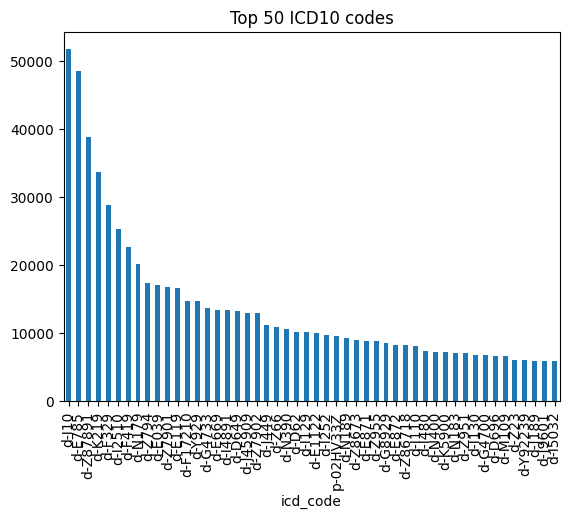

In [19]:
plot_top_n(mimic, "Top 50 ICD10 codes", 50, 10)

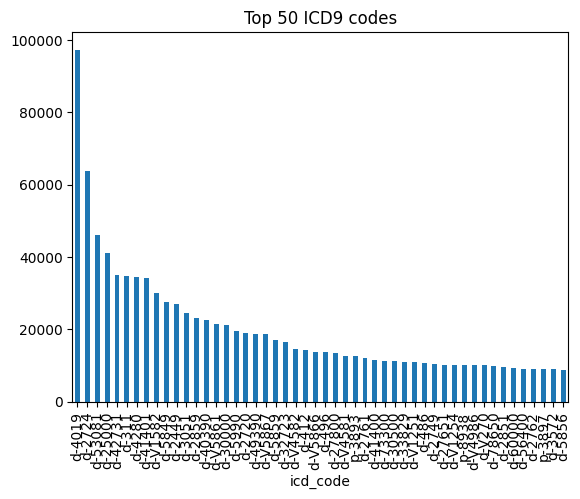

In [20]:
plot_top_n(mimic, "Top 50 ICD9 codes", 50, 9)

In [21]:
# Cleanup

# Drop all columns other than text and label
mimic_9 = mimic_9[["text", "label"]]
mimic_10 = mimic_10[["text", "label"]]

In [42]:
mimic_9_top50_codes = get_top_n_codes(mimic, 50, 9)
mimic_10_top50_codes = get_top_n_codes(mimic, 50, 10)

In [43]:
# Function to check if any item in the list is in L
def filter_labels(df, L):
    df['label'] = df['label'].apply(lambda labels: [label for label in labels if label in L])
    return df[df['label'].apply(len) > 0]


In [44]:
mimic_9_top50 = filter_labels(mimic_9.copy(), mimic_9_top50_codes)
mimic_10_top50 = filter_labels(mimic_10.copy(), mimic_10_top50_codes)


In [45]:
def count_unique_labels(df):
    # Flatten the list of lists in the 'label' column
    all_labels = [label for sublist in df['label'] for label in sublist]
    # Convert to a set to find unique labels and then count them
    unique_labels_count = len(set(all_labels))
    return unique_labels_count

# Testing the function on the DataFrame
unique_label_count = count_unique_labels(mimic_9_top50)
unique_label_count

50

In [46]:
# Report the number of entries, the average length of labels, average length of text, and the number of labels that occur more than 5 times

print("MIMIC-9-50")
print("Number of entries:", len(mimic_9_top50))
print("Average length of labels:", np.mean(mimic_9_top50['label'].apply(len)))
print("Average length of text:", np.mean(mimic_9_top50['text'].apply(len)))


print("MIMIC-10-50")
print("Number of entries:", len(mimic_10_top50))
print("Average length of labels:", np.mean(mimic_10_top50['label'].apply(len)))
print("Average length of text:", np.mean(mimic_10_top50['text'].apply(len)))

MIMIC-9-50
Number of entries: 93117
Average length of labels: 4.281656410752064
Average length of text: 8434.372885724411
MIMIC-10-50
Number of entries: 42210
Average length of labels: 5.023146173892442
Average length of text: 9367.560341151386


In [47]:
# Split into training, validation, and test sets
train_9 = mimic_9.sample(frac=0.8, random_state=0)
test_9 = mimic_9.drop(train_9.index)
val_9 = test_9.sample(frac=0.5, random_state=0)
test_9 = test_9.drop(val_9.index)

train_10 = mimic_10.sample(frac=0.8, random_state=0)
test_10 = mimic_10.drop(train_10.index)
val_10 = test_10.sample(frac=0.5, random_state=0)
test_10 = test_10.drop(val_10.index)


train_9_top50 = mimic_9_top50.sample(frac=0.8, random_state=0)
test_9_top50 = mimic_9_top50.drop(train_9_top50.index)
val_9_top50 = test_9_top50.sample(frac=0.5, random_state=0)
test_9_top50 = test_9_top50.drop(val_9_top50.index)

train_10_top50 = mimic_10_top50.sample(frac=0.8, random_state=0)
test_10_top50 = mimic_10_top50.drop(train_10_top50.index)
val_10_top50 = test_10_top50.sample(frac=0.5, random_state=0)
test_10_top50 = test_10_top50.drop(val_10_top50.index)

In [51]:
# Save dataset to disk
train_9.to_csv(DATA_FOLDER + "train_9.csv", index=False)
val_9.to_csv(DATA_FOLDER + "val_9.csv", index=False)
test_9.to_csv(DATA_FOLDER + "test_9.csv", index=False)

train_10.to_csv(DATA_FOLDER + "train_10.csv", index=False)
val_10.to_csv(DATA_FOLDER + "val_10.csv", index=False)
test_10.to_csv(DATA_FOLDER + "test_10.csv", index=False)

train_9_top50.to_csv(DATA_FOLDER + "train_9_top50.csv", index=False)
val_9_top50.to_csv(DATA_FOLDER + "val_9_top50.csv", index=False)
test_9_top50.to_csv(DATA_FOLDER + "test_9_top50.csv", index=False)

train_10_top50.to_csv(DATA_FOLDER + "train_10_top50.csv", index=False)
val_10_top50.to_csv(DATA_FOLDER + "val_10_top50.csv", index=False)
test_10_top50.to_csv(DATA_FOLDER + "test_10_top50.csv", index=False)

# Code list
icd9_codes.to_csv(DATA_FOLDER + "icd9_codes.csv", index=False)
icd10_codes.to_csv(DATA_FOLDER + "icd10_codes.csv", index=False)
mimic_9_top50_codes.reset_index().to_csv(DATA_FOLDER + "icd9_codes_top50.csv", index=False)
mimic_10_top50_codes.reset_index().to_csv(DATA_FOLDER + "icd10_codes_top50.csv", index=False)